# CPSC 330 Lecture 20

Outline:

- Announcements
- Gradient boosted trees, `Catboost` (15 min)
- Model comparison (15 min)
- Break (5 min)
- Big data sets: `SGDClassifier` and `SGDRegressor` (10 min)
- Multi-class classification (15 min)
- Combining multiple tables (10 min)
- True/False questions (15 min)

Reminder to self: **turn on recording!**

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier, DummyRegressor
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFE

In [110]:
from sklearn.metrics import plot_confusion_matrix

In [111]:
from pandas_profiling import ProfileReport

- These next 3 cells could just be replaced with `import load_process_data`.
- But this way I can make changes to that file and not need to restart my kernel each time.
- So it's convenient for development.

In [112]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
%autoreload 1

In [114]:
%aimport load_process_data

In [115]:
from plot_classifier import plot_classifier

In [116]:
plt.rcParams['font.size'] = 16

# NOTE

- this year we already introduced these in lecture 9
- but we still shoud talk about how CatBoost handles categoricals? And some other details below.

New dependency: `lightgbm`. Install with

`pip install lightgbm`

or 

`conda install -c conda-forge lightgbm`

(conda worked better for me in this case)

In [117]:
import lightgbm as lgb

New dependency: `xgboost`. Install with

`pip install xgboost`

or

`conda install -c conda-forge xgboost` 

New dependency: `catboost`. Install with

`pip install catboost`

or

`conda install -c conda-forge catboost` 

In [119]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [120]:
def show_scores_factory(X_train, y_train, X_test, y_test):
    def show_scores(model, **fit_kwargs):
        model.fit(X_train, y_train, **fit_kwargs);
        return model.score(X_test, y_test)
    return show_scores

## Announcements

Same as last class:

- hw7 has been posted, due Sunday evening.
  - I tried to make it shorter than previous assignments.
- Tutorials are still happening as scheduled, on Collaborate Ultra.
- Change to course grading scheme per Dean's directive; see [here](https://piazza.com/class/k1gx4b3djbv3ph?cid=319).

Today's class:

- A bunch of random things I wanted to cover at some point.
- Next week: communication and ethics (hopefully).

## Gradient boosted trees (15 min)

Recently a lot of the winning models have been one of the following:

|  Name   |  GitHub |  web/docs | Year | GitHub stars |
|---------|---------|---------|---------|--------------|
|  XGBoost | [link](https://github.com/dmlc/xgboost) | [link](https://xgboost.ai/) | 2016 | 19k
| LightGBM |  [link](https://github.com/microsoft/LightGBM) | [link](https://lightgbm.readthedocs.io/en/latest/) |  2017 | 11k |
| CatBoost | [link](https://github.com/catboost/catboost) | [link](https://catboost.ai/) | 2017 | 5k |

When I checked, all repos updated in the last 24 hrs (i.e., active development).

- All of these implement [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting), which is beyond the scope of the course.
  - And not covered in 340, but it probably should be!
- These 3 packages are fairly similar. Today I'll focus on CatBoost.
- I believe CatBoost and LightGBM seems to be performing better than XGBoost these days, but they are similar.

- I avoided these earlier in the course because I thought they'd be hard to install.
- It seems a lot of issues were solved since I tried XGBoost 1-2 years ago - it was easy!
- I think next time I might put these a lot earlier and use CatBoost instead of sklearn random forests everywhere, because I think it's a better choice. 

#### Categorical variables

- Of these 3, CatBoost is special because of how it handles categorical variables - hence "Cat".
- Thinking back to decision trees, we talked about splits like `Humidity > 1.2` or `Longitude > 90`. 
- Because we OHE categorical variables, it will give splits like `Location_Sydney > 0.5`, where that number 0.5 could be anywhere between 0 and 1. 
- (First off, there is no reason sklearn's decision trees or random forests need to require OHE; they could have easily learned rules like `Location == 'Sydney'`, which is equivalent to `Location_Sydney > 0.5` after OHE. I believe they didn't do this to be consistent with other sklearn estimators. However, I wonder if this makes performance worse, in particular for random forests.)
- However, is OHE the best encoding? Do we want 100 columns if there are 100 categories? What about `drop='first'` and `handle_error='ignore'`. It seems like a lot of hassle.
- CatBoost uses a more sophisticated encoding from categorical to numeric; see [here](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html#algorithm-main-stages_cat-to-numberic).
  - From the documentation: "Before each split is selected in the tree (see Choosing the tree structure), categorical features are transformed to numerical. This is done using various statistics on combinations of categorical features and combinations of categorical and numerical features."
  - This makes me think the conversion is done separately _at each split_.
  - So we can't just do this transformation in advance, it is entangled deeply with the algorithm. 
  - And also this makes sense, since the popularity of each value will change as your split the data.
  - Importantly, if there are 100 possible categories, you may not end up with 100 columns.
  - (From my reading of the documentation it looks like you end up with some smaller number of columns, depending on the type of _targets_: one per class for classification, and for regression this is controlled by a hyperparameter $k$.)
  - (Interestingly, the number of columns does not seem to depend on the number of possible categories of the categorical variable!)


In [121]:
X_train_housing, X_valid_housing, X_test_housing, y_train_housing, y_valid_housing, y_test_housing = load_process_data.load_housing()

In [122]:
X_train_housing.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Fence_?,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw
1341,-0.165978,0.338699,-0.062802,-0.505587,1.048406,0.927764,-0.577947,0.791412,-0.284437,-0.622612,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
459,-0.026237,-0.354633,-0.764983,-1.415471,-0.731683,-1.679272,0.294327,-0.544487,-0.284437,-0.120404,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
367,1.464330,-0.133037,-0.062802,-0.505587,-0.328644,-1.099931,1.074497,-0.149451,-0.284437,0.336963,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
894,-0.259139,-0.354322,-0.764983,-0.505587,0.242328,-0.279197,-0.577947,-0.937398,-0.284437,-1.295212,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
672,-0.026237,0.084927,-0.062802,0.404297,0.175155,-0.375754,-0.577947,0.691592,-0.284437,-0.306490,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [123]:
y_train_housing_log = np.log(y_train_housing)
y_valid_housing_log = np.log(y_valid_housing)
y_test_housing_log  = np.log(y_test_housing)

In [124]:
show_scores_housing = show_scores_factory(X_train_housing, y_train_housing_log, X_valid_housing, y_valid_housing_log)

In [125]:
show_scores_housing(Ridge())

0.8771971926959883

In [129]:
show_scores_housing(RandomForestRegressor())

0.8451189779530107

In [126]:
show_scores_housing(xgb.XGBRegressor())

0.8720378299606011

In [127]:
show_scores_housing(lgb.LGBMRegressor())

0.8642147899492177

In [128]:
show_scores_housing(CatBoostRegressor(), verbose=0)

0.9051122179357415

And now we try with proper handling of categorical variables:

In [130]:
X_train_housing_cat, X_valid_housing_cat, X_test_housing_cat, y_train_housing, y_valid_housing, y_test_housing, categorical_features = load_process_data.load_housing(ohe=False)

In [131]:
X_train_housing_cat.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MSSubClass,MoSold,SaleType,RoofMatl,LandContour,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,Fence
1341,-0.165978,0.338699,-0.0628021,-0.505587,1.04841,0.927764,-0.577947,0.791412,-0.284437,-0.622612,...,20,7,WD,CompShg,Lvl,No,GLQ,Unf,Typ,?
459,-0.0262374,-0.354633,-0.764983,-1.41547,-0.731683,-1.67927,0.294327,-0.544487,-0.284437,-0.120404,...,50,7,WD,CompShg,Bnk,No,LwQ,Unf,Typ,?
367,1.46433,-0.133037,-0.0628021,-0.505587,-0.328644,-1.09993,1.0745,-0.149451,-0.284437,0.336963,...,80,12,WD,Tar&Grv,Lvl,Gd,GLQ,Unf,Typ,?
894,-0.259139,-0.354322,-0.764983,-0.505587,0.242328,-0.279197,-0.577947,-0.937398,-0.284437,-1.29521,...,90,6,WD,CompShg,Bnk,?,?,?,Typ,?
672,-0.0262374,0.0849273,-0.0628021,0.404297,0.175155,-0.375754,-0.577947,0.691592,-0.284437,-0.30649,...,20,6,WD,CompShg,Lvl,No,ALQ,Unf,Typ,?


In [133]:
X_train_housing_cat[categorical_features].head()

,CentralAir,Utilities,GarageType,PavedDrive,Neighborhood,MasVnrType,BldgType,GarageFinish,Heating,HouseStyle,...,MSSubClass,MoSold,SaleType,RoofMatl,LandContour,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,Fence
1341,Y,AllPub,Detchd,Y,SawyerW,None,1Fam,Unf,GasA,1Story,...,20,7,WD,CompShg,Lvl,No,GLQ,Unf,Typ,?
459,Y,AllPub,Detchd,Y,BrkSide,BrkCmn,1Fam,Unf,GasA,1.5Fin,...,50,7,WD,CompShg,Bnk,No,LwQ,Unf,Typ,?
367,Y,AllPub,Basment,Y,NAmes,BrkFace,1Fam,RFn,GasA,SLvl,...,80,12,WD,Tar&Grv,Lvl,Gd,GLQ,Unf,Typ,?
894,Y,AllPub,Attchd,Y,SawyerW,None,Duplex,Unf,GasA,1Story,...,90,6,WD,CompShg,Bnk,?,?,?,Typ,?
672,Y,AllPub,Attchd,Y,Veenker,None,1Fam,RFn,GasA,1Story,...,20,6,WD,CompShg,Lvl,No,ALQ,Unf,Typ,?


In [134]:
print(", ".join(categorical_features))

CentralAir, Utilities, GarageType, PavedDrive, Neighborhood, MasVnrType, BldgType, GarageFinish, Heating, HouseStyle, LotShape, LotConfig, Electrical, KitchenAbvGr, Condition1, MiscFeature, Street, Alley, LandSlope, RoofStyle, Exterior2nd, Condition2, Exterior1st, MSZoning, SaleCondition, BedroomAbvGr, Foundation, MSSubClass, MoSold, SaleType, RoofMatl, LandContour, BsmtExposure, BsmtFinType1, BsmtFinType2, Functional, Fence


In [135]:
cat = CatBoostRegressor(cat_features=categorical_features)
cat.fit(X_train_housing_cat, y_train_housing_log, verbose=100);

Learning rate set to 0.039377
0:	learn: 0.3951997	total: 46.5ms	remaining: 46.5s
100:	learn: 0.1249415	total: 5.66s	remaining: 50.4s
200:	learn: 0.1002285	total: 11.7s	remaining: 46.5s
300:	learn: 0.0892388	total: 18.7s	remaining: 43.5s
400:	learn: 0.0809382	total: 23.7s	remaining: 35.4s
500:	learn: 0.0736061	total: 30.2s	remaining: 30.1s
600:	learn: 0.0665125	total: 38.5s	remaining: 25.6s
700:	learn: 0.0609587	total: 44.1s	remaining: 18.8s
800:	learn: 0.0561925	total: 50.1s	remaining: 12.4s
900:	learn: 0.0522277	total: 56.7s	remaining: 6.23s
999:	learn: 0.0483357	total: 1m 1s	remaining: 0us


In [136]:
cat.score(X_valid_housing_cat, y_valid_housing_log)

0.9034631808902006

In this case the code ran slower and it didn't seem to help, but I suspect it will in some cases!

#### Feature importances

- The syntax for getting feature importances is a bit clunky.
- You first need to create a `catboost.Pool` object storing the data:

In [137]:
train_data_pool = Pool(X_train_housing_cat, y_train_housing_log, cat_features=categorical_features)

And then you can get feature importances:

In [138]:
importances = cat.get_feature_importance(train_data_pool)

And we can display them as usual:

In [139]:
importances = pd.DataFrame(data=importances, index=X_train_housing_cat.columns, columns=["Importance"])
importances.sort_values(by="Importance", ascending=False)

,Importance
OverallQual,17.132160
GrLivArea,15.718205
TotalBsmtSF,6.045116
ExterQual,3.995476
GarageCars,3.933389
...,...
Street,0.003121
LowQualFinSF,0.001376
BsmtHalfBath,0.000309
PoolQC,0.000113


In [140]:
print(", ".join(categorical_features))

CentralAir, Utilities, GarageType, PavedDrive, Neighborhood, MasVnrType, BldgType, GarageFinish, Heating, HouseStyle, LotShape, LotConfig, Electrical, KitchenAbvGr, Condition1, MiscFeature, Street, Alley, LandSlope, RoofStyle, Exterior2nd, Condition2, Exterior1st, MSZoning, SaleCondition, BedroomAbvGr, Foundation, MSSubClass, MoSold, SaleType, RoofMatl, LandContour, BsmtExposure, BsmtFinType1, BsmtFinType2, Functional, Fence


- You can also get SHAP values, both through the SHAP package or built-in to CatBoost.
- With proper handling of categorical variables, we can see an importance for the entire categorical variable, not just one possible value of it, which is kind of nice.

## Model comparison (15 min)

Very rough rule of thumb, when working on a problem with **tabular data**, try the following, in order: 

1. `DummyRegressor` or `DummyClassifer`
2. `HuberRegressor` or `LogisticRegression`
3. `CatBoostRegressor` or `CatBoostClassifier`

We'll now do a "bake-off" between different models and different datasets in the course, following the outlier scavenger hunt from L19.

#### Census data (lecture 7)

In [141]:
X_train_adult, y_train_adult, X_test_adult, y_test_adult, _ = load_process_data.load_adult()
X_train_adult.shape

(26048, 100)

In [142]:
X_train_adult.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
17064,-1.364769,-0.745073,-0.027403,-0.146669,-0.216807,-0.845065,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18434,-1.217915,0.708967,-0.416178,-0.146669,-0.216807,3.204805,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3294,0.911476,1.397806,-0.416178,0.451354,-0.216807,1.179870,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
31317,1.058330,-0.736111,1.138922,-0.146669,-0.216807,-0.440078,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4770,0.984903,-1.316034,1.138922,-0.146669,-0.216807,1.179870,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [143]:
show_scores_adult = show_scores_factory(X_train_adult, y_train_adult, X_test_adult, y_test_adult)

In [144]:
show_scores_adult(DummyClassifier(strategy="prior"))

0.7538768616612928

In [145]:
show_scores_adult(LogisticRegression(max_iter=1000))

0.8510670965760786

In [146]:
show_scores_adult(xgb.XGBClassifier())

0.8711807154920927

In [147]:
show_scores_adult(lgb.LGBMClassifier())

0.8745585751573776

In [148]:
show_scores_adult(CatBoostClassifier(), verbose=100)

0.8730231844004299

In [149]:
X_train_adult_cat, y_train_adult, X_test_adult_cat, y_test_adult, cat_features_adult = load_process_data.load_adult(ohe=False)

In [150]:
X_train_adult_cat.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass,education,marital.status,occupation,relationship,race,sex,native.country
17064,-1.36477,-0.745073,-0.0274029,-0.146669,-0.216807,-0.845065,Private,Some-college,Never-married,Adm-clerical,Own-child,Asian-Pac-Islander,Female,United-States
18434,-1.21791,0.708967,-0.416178,-0.146669,-0.216807,3.2048,Private,HS-grad,Never-married,Other-service,Own-child,Black,Male,United-States
3294,0.911476,1.39781,-0.416178,0.451354,-0.216807,1.17987,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
31317,1.05833,-0.736111,1.13892,-0.146669,-0.216807,-0.440078,Private,Bachelors,Married-civ-spouse,Other-service,Husband,White,Male,United-States
4770,0.984903,-1.31603,1.13892,-0.146669,-0.216807,1.17987,Self-emp-inc,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,United-States


In [151]:
cat = CatBoostClassifier(cat_features=cat_features_adult)
cat.fit(X_train_adult_cat, y_train_adult, verbose=100);

Learning rate set to 0.041445
0:	learn: 0.6486984	total: 80.6ms	remaining: 1m 20s
100:	learn: 0.2916250	total: 16.4s	remaining: 2m 25s
200:	learn: 0.2780044	total: 29.3s	remaining: 1m 56s
300:	learn: 0.2681981	total: 38.4s	remaining: 1m 29s
400:	learn: 0.2609732	total: 45.9s	remaining: 1m 8s
500:	learn: 0.2558415	total: 54.1s	remaining: 53.9s
600:	learn: 0.2517539	total: 1m 9s	remaining: 46s
700:	learn: 0.2480964	total: 1m 20s	remaining: 34.5s
800:	learn: 0.2447137	total: 1m 28s	remaining: 22s
900:	learn: 0.2418840	total: 1m 36s	remaining: 10.6s
999:	learn: 0.2387305	total: 1m 43s	remaining: 0us


In [152]:
cat.score(X_test_adult_cat, y_test_adult)

0.8728696453247351

# TODO

compare on AUC as well, accuracy might not be as meaningful

#### Movie review data (lecture 5)

In [153]:
X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb = load_process_data.load_movie()
X_train_imdb.shape

(8000, 2699)

In [155]:
type(X_train_imdb)

scipy.sparse.csr.csr_matrix

In [156]:
show_scores_movie = show_scores_factory(X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb)

In [157]:
show_scores_movie(DummyClassifier(strategy="prior"))

0.4935

In [158]:
show_scores_movie(LogisticRegression(max_iter=1000))

0.838

In [159]:
show_scores_movie(xgb.XGBClassifier())

0.8415

LightGBM seems to kill my kernel in this case... too many features?? Or maybe it can't handle sparse matrices as input? That seems surprising though.

In [ ]:
# show_scores_movie(lgb.LGBMClassifier())

In [160]:
show_scores_movie(CatBoostClassifier(), verbose=100)

Learning rate set to 0.025035
0:	learn: 0.6858406	total: 125ms	remaining: 2m 4s
100:	learn: 0.4950686	total: 11.6s	remaining: 1m 43s
200:	learn: 0.4394911	total: 22.5s	remaining: 1m 29s
300:	learn: 0.4038004	total: 33.2s	remaining: 1m 17s
400:	learn: 0.3718700	total: 42.8s	remaining: 1m 3s
500:	learn: 0.3415765	total: 52.7s	remaining: 52.5s
600:	learn: 0.3163704	total: 1m 5s	remaining: 43.2s
700:	learn: 0.2956700	total: 1m 13s	remaining: 31.6s
800:	learn: 0.2776943	total: 1m 24s	remaining: 20.9s
900:	learn: 0.2614404	total: 1m 33s	remaining: 10.2s
999:	learn: 0.2472331	total: 1m 49s	remaining: 0us


0.8595

There are no categorical features here (they are all word counts), so no need to do another experiment.

#### Rain in Australia data (lecture 16)

In [161]:
X_train_rain, y_train_rain, X_test_rain, y_test_rain, _ = load_process_data.load_rain()
X_train_rain.shape

(107502, 125)

In [162]:
show_scores_rain = show_scores_factory(X_train_rain, y_train_rain, X_test_rain, y_test_rain)

In [163]:
show_scores_rain(DummyClassifier(strategy="prior"))

0.7781845435415525

In [164]:
show_scores_rain(LogisticRegression(max_iter=1000))

0.8454354155256406

In [165]:
show_scores_rain(xgb.XGBClassifier(verbosity=1))

0.8550632728949872

In [166]:
show_scores_rain(lgb.LGBMClassifier())

0.8536219768816119

In [167]:
show_scores_rain(CatBoostClassifier(), verbose=100)

Learning rate set to 0.075919
0:	learn: 0.6417575	total: 52.8ms	remaining: 52.7s
100:	learn: 0.3397858	total: 6.78s	remaining: 1m
200:	learn: 0.3249774	total: 14.3s	remaining: 57s
300:	learn: 0.3139556	total: 21.8s	remaining: 50.6s
400:	learn: 0.3049408	total: 28.3s	remaining: 42.3s
500:	learn: 0.2972943	total: 36.2s	remaining: 36s
600:	learn: 0.2904276	total: 44.7s	remaining: 29.7s
700:	learn: 0.2841649	total: 51.3s	remaining: 21.9s
800:	learn: 0.2783169	total: 1m	remaining: 15s
900:	learn: 0.2727251	total: 1m 8s	remaining: 7.51s
999:	learn: 0.2675276	total: 1m 14s	remaining: 0us


0.8593006831743103

In [168]:
X_train_rain_cat, _, X_test_rain_cat, _, cat_features_rain = load_process_data.load_rain(ohe=False)
X_train_rain_cat.shape

(107502, 26)

In [171]:
X_train_rain_cat.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Rainfall_lag1,Rainfall_lag2,Rainfall_lag3,Humidity3pm_lag1,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,Month
0,0.204302,-0.0271117,-0.205323,-0.140641,0.160729,0.298612,0.666166,0.599894,0.115428,-1.43351,...,-0.274971,-0.274913,-0.274905,0.021742,Albury,W,W,WNW,No,12
1,-0.741037,0.287031,-0.275008,-0.140641,0.160729,0.298612,-1.12562,0.373275,-1.31493,-1.288,...,-0.205283,-0.274913,-0.274905,-1.43362,Albury,WNW,NNW,WSW,No,12
2,0.125523,0.372706,-0.275008,-0.140641,0.160729,0.450132,0.55418,0.826513,-1.63279,-1.04548,...,-0.274971,-0.205215,-0.274905,-1.28808,Albury,WSW,W,WSW,No,12
3,-0.457435,0.701128,-0.275008,-0.140641,0.160729,-1.2166,-0.341712,-1.09975,-1.26195,-1.72454,...,-0.274971,-0.274913,-0.205207,-1.04552,Albury,NE,SE,E,No,12
4,0.850283,1.31513,-0.158867,-0.140641,0.160729,0.0713304,-0.789657,0.146656,0.698167,-0.899969,...,-0.274971,-0.274913,-0.274905,-1.72469,Albury,W,ENE,NW,No,12


In [169]:
cat = CatBoostClassifier(iterations=500, cat_features=cat_features_rain)
cat.fit(X_train_rain_cat, y_train_rain, verbose=50);

Learning rate set to 0.143349
0:	learn: 0.5970566	total: 336ms	remaining: 2m 47s
50:	learn: 0.3339990	total: 15.8s	remaining: 2m 18s
100:	learn: 0.3198865	total: 28.8s	remaining: 1m 53s
150:	learn: 0.3101000	total: 41.6s	remaining: 1m 36s
200:	learn: 0.3027833	total: 54.8s	remaining: 1m 21s
250:	learn: 0.2968515	total: 1m 47s	remaining: 1m 47s
300:	learn: 0.2914525	total: 1m 58s	remaining: 1m 18s
350:	learn: 0.2869166	total: 2m 9s	remaining: 55.1s
400:	learn: 0.2821816	total: 2m 23s	remaining: 35.5s
450:	learn: 0.2779684	total: 2m 46s	remaining: 18.1s
499:	learn: 0.2739957	total: 3m 17s	remaining: 0us


In [170]:
cat.score(X_test_rain_cat, y_test_rain)

0.8617508863970482

#### Discussion

- Overall CatBoost looks like a good bet. 
- We didn't do any hyperparameter tuning, this might change the results. Maybe they just have better defaults.
  - In fact, we did not discuss hyperparameters at all for these fancy models.
  - There are a ton of them!
  - For CatBoost, a main hyperparameter controlling the fundamental tradeoff is `iterations`. 
    - This is similar to `n_estimators` in the sklearn random forests: larger = more complex models.
  - Another main hyperparameter is `learning_rate` but its interpretation is a bit beyond our scope.
  - These models should all be compatible with `RandomizedSearchCV`, etc.
  - But CatBoost, at least, does not work out of the box for feature selection with `RFE`/`RFECV`
- But I think it's pretty good. A bit slow though.
  - Now that speed is an issue, we should note that increasing complexity via `iterations` also increases runtime.
  - This is not always true, e.g. `gamma` in SVM and (for the most part) `C` in `LogisticRegression`.
  - But in fact often we did get increased runtime with more complexity, e.g. more features from `CountVectorizer`. 
- I'm surprising that feeding in the raw categorical features doesn't seem to help in many cases. 
  - Isn't that the point of CatBoost?!
  - It does seem to help with the Rain data.
  - I will need to look into this more at some point.
    - Maybe the code needs to be run for longer in these cases?
    - Hyperparameter tuning should be done in each case, at least a bit.

## Break (5 min)

## Big data sets: `SGDClassifier` and `SGDRegressor` (10 min)


- Something we haven't discussed in this course is huge data sets.
- There could be a couple problems arising from huge data sets:

1. The code is too slow.
2. The dataset doesn't fit in memory - I can't even load it with `pd.read_csv`. 

- "SGD" (stochastic gradient descent) can help with both of these problems.
- But we'll focus on using it to solve problem (1).
- There is a fancy way to implement `fit` that can be a lot faster for big data sets.
  - You can think of it as quickly finding "approximately" the best coefficients when calling `fit`.
  - That is not quite true but it may be a useful way of thinking.
  - Much more on this in CPSC 340 and much, much more on this in CPSC 440/540.

- SGD can be used in many contexts.
- In sklearn, it's built in as follows:

In [172]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

- `SGDRegressor` is basically equivalent to `Ridge`.
- `SGDRegressor(loss='huber')` is basically equivalent to `HuberRegressor`.
- `SGDClassifier(loss='log')` is basically equivalent to `LogisticRegression`, except the parameter is called `alpha` instead of `C` (like `Ridge`).
- With other settings they are equivalent to other models, but this is good enough.

- For regular sized datasets, use the original functions, as these ones can be a bit more finicky. 

Let's load the [Sentiment140 dataset](http://help.sentiment140.com/home), which contains tweets labeled with sentiment associated with a brand, product, or topic. (I don't think we've looked at this dataset before - using it here because it's large.)

In [173]:
tweets_df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', 
                        encoding = "ISO-8859-1",
                        names=["label","id", "date", "no_query", "name", "text"])
tweets_df['label'] = tweets_df['label'].map({0: 'neg', 4: 'pos'})
tweets_df = tweets_df[tweets_df['label'].str.startswith(('pos','neg'))]

In [174]:
tweets_df_train, tweets_df_test = train_test_split(tweets_df)

In [175]:
tweets_df_train.head()

,label,id,date,no_query,name,text
623519,neg,2229582799,Thu Jun 18 15:55:25 PDT 2009,NO_QUERY,Asmcqu01,@mcquage Yep I'm coming home...what's sad thou...
1210683,pos,1989074133,Mon Jun 01 00:15:38 PDT 2009,NO_QUERY,DaWaBZ94,"@bb_nation Hi 9h in paris, started gravity - w..."
1385171,pos,2052722086,Sat Jun 06 01:46:04 PDT 2009,NO_QUERY,Desmond_Ong,@ianternet haha...play online games ian.
1488275,pos,2068458374,Sun Jun 07 14:06:50 PDT 2009,NO_QUERY,TheWendyHouse,Evening all! That didn't take long did it? Ha ...
1306867,pos,2012075176,Tue Jun 02 20:01:44 PDT 2009,NO_QUERY,sarasmile13,@nakeddmblauren I will go back to my self-pity...


In [176]:
tweets_df_train.shape

(1200000, 6)

Holy cow!

In [177]:
vec = CountVectorizer(stop_words='english')

X_train = vec.fit_transform(tweets_df_train['text']) 
y_train = tweets_df_train['label']

X_test = vec.transform(tweets_df_test['text']) 
y_test = tweets_df_test['label']

In [178]:
X_train.shape

(1200000, 563585)

In [179]:
type(X_train)

scipy.sparse.csr.csr_matrix

Here is the fraction of elements that are nonzero. Having a sparse matrix really helps!!

In [180]:
X_train.nnz/np.prod(X_train.shape)

1.2346648390807657e-05

Now let's train a classifier. I'll use `time` instead of `%timeit` because I want to keep the output, and it gets lost with `%timeit`.

In [181]:
lr = LogisticRegression()

In [182]:
%%time

lr.fit(X_train, y_train);

CPU times: user 1min 2s, sys: 2.53 s, total: 1min 5s
Wall time: 54.6 s


/Users/mgelbart/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [183]:
lr.score(X_train, y_train)

0.8160875

In [184]:
lr.score(X_test, y_test)

0.7780825

In [185]:
lr_sgd = SGDClassifier(loss="log")

In [186]:
%%time

lr_sgd.fit(X_train, y_train);

CPU times: user 5.71 s, sys: 125 ms, total: 5.84 s
Wall time: 6.97 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [187]:
lr_sgd.n_iter_

7

In [188]:
lr_sgd.score(X_train, y_train)

0.7695383333333333

In [189]:
lr_sgd.score(X_test, y_test)

0.76628

- `SGDClassifier` was about 10x faster than `LogisticRegression`, but the accuracy is slightly lower.
- In fact, we can control the speed vs. _train_ accuracy tradeoff in both cases using the hyperparameters.
  - The main ones are `max_iter` (higher is slower) and/or `tol` (lower is slower)
  - (This is the same for both `LogisticRegression` and `SGDClassifier`)
- In general, `LogisticRegression` will get slightly higher _train_ accuracy (may or may not correspond to better validation/test)
- But in some cases your dataset is so big that `LogisticRegression` is not feasible, and then `SGDClassifier` can save the day.

Random comment: last time I tried this was with sklearn 0.21.3 and scipy 1.3.1 a few months ago, now with skearln 0.22.1 and scipy 1.4.1. I wonder if `LogisticRegression`, or the underlying optimizer in scipy, was improved at all in these recent upgrades, because it seems to be faster now than last time.

## Multi-class classification (15 min)


- I intended to cover this at some point but it didn't really come up naturally.
- We briefly talked about it in Lecture 14 on neural networks & computer vision.
- Most of the classification problems we looked at were binary classification (2 possible labels)
- There are plenty of multi-class classification problems as well.

In [190]:
data = sklearn.datasets.load_wine()
X = pd.DataFrame(data['data'], columns=data["feature_names"])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [191]:
X_train

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
109,11.61,1.35,2.70,20.0,94.0,2.74,2.92,0.29,2.49,2.65,0.960,3.26,680.0
106,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.000,3.17,510.0
134,12.51,1.24,2.25,17.5,85.0,2.00,0.58,0.60,1.25,5.45,0.750,1.51,650.0
89,12.08,1.33,2.30,23.6,70.0,2.20,1.59,0.42,1.38,1.74,1.070,3.21,625.0
12,13.75,1.73,2.41,16.0,89.0,2.60,2.76,0.29,1.81,5.60,1.150,2.90,1320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.240,3.37,1265.0
62,13.67,1.25,1.92,18.0,94.0,2.10,1.79,0.32,0.73,3.80,1.230,2.46,630.0
70,12.29,1.61,2.21,20.4,103.0,1.10,1.02,0.37,1.46,3.05,0.906,1.82,870.0
71,13.86,1.51,2.67,25.0,86.0,2.95,2.86,0.21,1.87,3.38,1.360,3.16,410.0


In [192]:
y_train

array([1, 1, 2, 1, 0, 2, 1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 2,
       0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 2, 2, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 2, 2, 1, 2, 1, 2, 0, 0, 1, 1, 2, 2, 1, 0, 1,
       1, 0, 2, 0, 2, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 2, 0, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       0])

- Note that we have 3 classes here: 0, 1, 2.
- For some models, like a random forest, we don't have to think about anything differently at all:

In [193]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train);

In [194]:
rf.predict(X_test)

array([0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2,
       1])

In [195]:
rf_importances = pd.DataFrame(data=rf.feature_importances_, index=X_train.columns, columns=["Importance"])
rf_importances.sort_values(by="Importance")

,Importance
ash,0.011616
nonflavanoid_phenols,0.012012
proanthocyanins,0.012043
alcalinity_of_ash,0.016882
magnesium,0.029298
malic_acid,0.045506
total_phenols,0.045682
hue,0.083974
color_intensity,0.107607
od280/od315_of_diluted_wines,0.119953


- Everything is the same here.
- For our linear classifier, on the other hand, things are a bit different:

In [196]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train);

In [197]:
lr.predict(X_test)

array([0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2,
       1])

In [204]:
lr.predict_proba(X_test)[:10]

array([[9.83121095e-01, 1.30404370e-02, 3.83846763e-03],
       [9.95736967e-01, 1.69179383e-03, 2.57123874e-03],
       [9.99913071e-01, 4.17255306e-06, 8.27563492e-05],
       [2.21058877e-03, 9.97237440e-01, 5.51971365e-04],
       [1.55535649e-03, 1.51962649e-03, 9.96925017e-01],
       [1.40295571e-04, 9.99655016e-01, 2.04688647e-04],
       [1.77145916e-03, 1.22119079e-02, 9.86016633e-01],
       [9.99998530e-01, 1.01172179e-10, 1.46997299e-06],
       [9.99957179e-01, 1.40043113e-05, 2.88168294e-05],
       [9.96393323e-01, 2.52352829e-04, 3.35432433e-03]])

In [205]:
np.argmax(lr.predict_proba(X_test), axis=1)

array([0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2,
       1])

In [206]:
lr.predict(X_test)

array([0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2,
       1])

In [198]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=X_train.columns, columns=["Coefficient"])
lr_coefs.sort_values(by="Coefficient")

ValueError: Shape of passed values is (3, 13), indices imply (13, 1)

What is going on here?

In [199]:
lr.coef_.shape

(3, 13)

What's happening here is that we have one coefficient per feature _per class_. 

In [200]:
lr_coefs = pd.DataFrame(data=lr.coef_.T, index=X_train.columns, columns=lr.classes_)
lr_coefs

,0,1,2
alcohol,0.660312,-0.691072,0.030761
malic_acid,0.540192,-0.791026,0.250834
ash,0.708200,-0.874055,0.165855
alcalinity_of_ash,-0.211434,0.122472,0.088962
magnesium,-0.019100,-0.016223,0.035323
total_phenols,0.247848,0.154682,-0.402530
flavanoids,0.804320,0.425621,-1.229941
nonflavanoid_phenols,0.087637,0.024024,-0.111661
proanthocyanins,0.076671,0.395400,-0.472071
color_intensity,0.186333,-0.948383,0.762051


In [202]:
# lr_coefs.sum(axis=1)

The interpretation is a feature importance for predicting a certain class. For example:

In [ ]:
lr_coefs.loc["alcohol", 2]

- Means that if alcohol is larger, you are more likely to predict class 2. 
- The specific interpretation depends on the way the logistic regression is implementing multi-class.

In [208]:
# ?LogisticRegression

- We can see that there's a `multi_class` parameter, that can be set to `'ovr'` or `'multinomial'`, or you can have it automatically choose between the two, which is the default.
  - In CPSC 340 we discuss in detail the difference between these two approaches.
  - In CPSC 340 we make an argument for preferring `'multinomial'`, but in short it doesn't matter which one you choose.
- If you want a general feature importance irrespective of class, you could try looking for features where the coefficients have large absolute values.

In [211]:
# lr_multi = LogisticRegression(max_iter=10000, multi_class='multinomial')
# lr_multi.fit(X_train, y_train);

In [212]:
# lr_multi_coefs = pd.DataFrame(data=lr_multi.coef_.T, index=X_train.columns, columns=lr.classes_)
# lr_multi_coefs

Note that the output of `predict_proba` now contains a probability for each class:

In [213]:
lr.predict_proba(X_test)[:5]

array([[9.83121095e-01, 1.30404370e-02, 3.83846763e-03],
       [9.95736967e-01, 1.69179383e-03, 2.57123874e-03],
       [9.99913071e-01, 4.17255306e-06, 8.27563492e-05],
       [2.21058877e-03, 9.97237440e-01, 5.51971365e-04],
       [1.55535649e-03, 1.51962649e-03, 9.96925017e-01]])

And you'll see that each row adds up to 1, as expected:

In [214]:
np.sum(lr.predict_proba(X_test), axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

We can still make a confusion matrix:

In [215]:
confusion_matrix(y_test, lr.predict(X_test))

array([[14,  0,  0],
       [ 0, 19,  0],
       [ 0,  0, 12]])

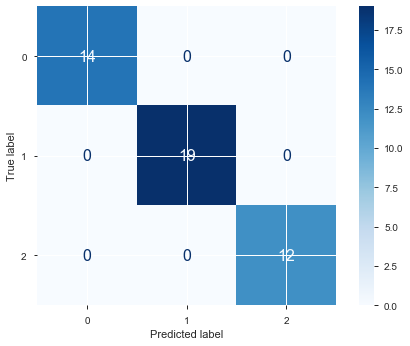

In [216]:
plot_confusion_matrix(lr, X_test, y_test, display_labels=lr.classes_, cmap=plt.cm.Blues, values_format = 'd');

- Precision, recall, etc. don't apply directly.
- But if we pick one of the classes as positive, and consider the rest to be negative, then we can.

In [217]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



- We can also make the plots we made earlier in the course, but this time with more classes.
- I need to train a model with only 2 features for this to work:

In [218]:
lr_2f = LogisticRegression()
lr_2f.fit(X_train.iloc[:,:2], y_train);

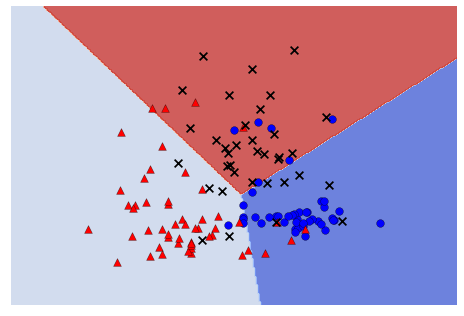

In [219]:
plot_classifier(X_train.iloc[:,:2], y_train, lr_2f);

Note: the colours aren't very good - the red triangles correspond to the light blue predictions, the black X's correspond to the red predictions, and the blue circles (correctly) correspond to the blue circles.

We can do the same with a random forest:

In [220]:
rf_2f = RandomForestClassifier()
rf_2f.fit(X_train.iloc[:,:2], y_train);

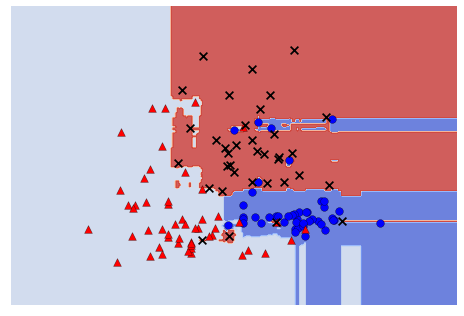

In [221]:
plot_classifier(X_train.iloc[:,:2], y_train, rf_2f);

Or an RBF SVM:

In [222]:
svm_2f = SVC(kernel="rbf", gamma=2, C=100)
svm_2f.fit(X_train.iloc[:,:2], y_train);

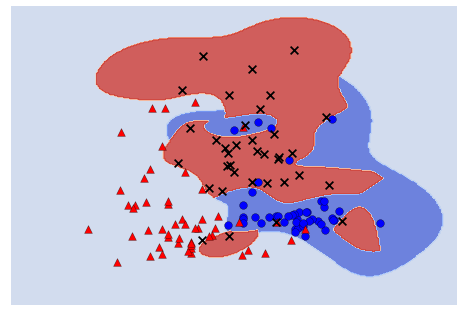

In [223]:
plot_classifier(X_train.iloc[:,:2], y_train, svm_2f);

## Combining multiple tables (10 min)


- Take a look at the [Formula 1 race data set](https://www.kaggle.com/cjgdev/formula-1-race-data-19502017) from Kaggle. 
- The dataset contains **multiple CSV files**.
- Let's read in one of them:

In [224]:
racing_results_df = pd.read_csv("data/formula-1-race-data-19502017/results.csv", index_col=0)
racing_results_df

,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
resultId,,,,,,,,,,,,,,,,,
1,18,1,1,22.0,1,1.0,1,1,10.0,58,34:50.6,5690616.0,39.0,2.0,01:27.5,218.3,1
2,18,2,2,3.0,5,2.0,2,2,8.0,58,5.478,5696094.0,41.0,3.0,01:27.7,217.586,1
3,18,3,3,7.0,7,3.0,3,3,6.0,58,8.163,5698779.0,41.0,5.0,01:28.1,216.719,1
4,18,4,4,5.0,11,4.0,4,4,5.0,58,17.181,5707797.0,58.0,7.0,01:28.6,215.464,1
5,18,5,1,23.0,3,5.0,5,5,4.0,58,18.014,5708630.0,43.0,1.0,01:27.4,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23777,988,842,5,10.0,17,16.0,16,16,0.0,54,NaN,NaN,33.0,16.0,01:43.8,192.542,11
23778,988,828,15,9.0,19,17.0,17,17,0.0,54,NaN,NaN,36.0,15.0,01:43.6,193.057,11
23779,988,840,3,18.0,15,18.0,18,18,0.0,54,NaN,NaN,52.0,6.0,01:42.3,195.402,11


- Let's say we want to predict the `milliseconds` column, namely the total length of time it takes a driver to finish a race. 
- In that case, we should not have access to most of these other columns. 
- But we would have the `raceId` and `driverId`:

In [225]:
racing_results_df_subset = racing_results_df[['raceId', 'driverId', 'milliseconds']]
racing_results_df_subset

,raceId,driverId,milliseconds
resultId,,,
1,18,1,5690616.0
2,18,2,5696094.0
3,18,3,5698779.0
4,18,4,5707797.0
5,18,5,5708630.0
...,...,...,...
23777,988,842,NaN
23778,988,828,NaN
23779,988,840,NaN


In [227]:
racing_results_df_subset.sort_values(by="driverId")

,raceId,driverId,milliseconds
resultId,,,
1,18,1,5690616.0
23745,987,1,5491730.0
22089,898,1,5984506.0
20611,349,1,5344268.0
23115,957,1,5695831.0
...,...,...,...
23675,983,842,NaN
23776,988,843,NaN
23714,985,843,NaN


# TODO

for fun, try to predict milliseconds just based on raceId and driverId

- Now we need some features to predict the race time. 
- Enter the other tables:

In [226]:
racing_drivers_df = pd.read_csv("data/formula-1-race-data-19502017/drivers.csv", 
                                encoding='latin-1', index_col=0,
                               parse_dates=['dob'])
racing_drivers_df

,driverRef,number,code,forename,surname,dob,nationality,url
driverId,,,,,,,,
1,hamilton,44.0,HAM,Lewis,Hamilton,1985-07-01,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
2,heidfeld,NaN,HEI,Nick,Heidfeld,1977-10-05,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
3,rosberg,6.0,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
4,alonso,14.0,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
5,kovalainen,NaN,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen
...,...,...,...,...,...,...,...,...
838,vandoorne,2.0,VAN,Stoffel,Vandoorne,1992-03-26,Belgian,http://en.wikipedia.org/wiki/Stoffel_Vandoorne
839,ocon,31.0,OCO,Esteban,Ocon,1996-09-17,French,http://en.wikipedia.org/wiki/Esteban_Ocon
840,stroll,18.0,STR,Lance,Stroll,1998-10-29,Canadian,http://en.wikipedia.org/wiki/Lance_Stroll


- Can we use the driver's nationality and age as features?
- `pd.merge` can take care of this for us.

In [228]:
merged_df = pd.merge(racing_results_df_subset, racing_drivers_df, on="driverId")
merged_df

,raceId,driverId,milliseconds,driverRef,number,code,forename,surname,dob,nationality,url
0,18,1,5690616.0,hamilton,44.0,HAM,Lewis,Hamilton,1985-07-01,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,19,1,5525103.0,hamilton,44.0,HAM,Lewis,Hamilton,1985-07-01,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
2,20,1,NaN,hamilton,44.0,HAM,Lewis,Hamilton,1985-07-01,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
3,21,1,5903238.0,hamilton,44.0,HAM,Lewis,Hamilton,1985-07-01,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
4,22,1,5213230.0,hamilton,44.0,HAM,Lewis,Hamilton,1985-07-01,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
...,...,...,...,...,...,...,...,...,...,...,...
23772,988,842,NaN,gasly,10.0,GAS,Pierre,Gasly,1996-07-02,French,http://en.wikipedia.org/wiki/Pierre_Gasly
23773,985,843,NaN,brendon_hartley,39.0,HAR,Brendon,Hartley,1989-10-11,New Zealander,http://en.wikipedia.org/wiki/Brendon_Hartley
23774,986,843,NaN,brendon_hartley,39.0,HAR,Brendon,Hartley,1989-10-11,New Zealander,http://en.wikipedia.org/wiki/Brendon_Hartley
23775,987,843,NaN,brendon_hartley,39.0,HAR,Brendon,Hartley,1989-10-11,New Zealander,http://en.wikipedia.org/wiki/Brendon_Hartley


- The `on` keyword told it which column to use to match up the rows of the two dataframes.
- Note that the first 5 rows have the same `driverId`, so they pulled the same data from `racing_drivers_df`.
- Now we could keep only the columns we plan to encode:

In [229]:
merged_df_subset = merged_df[['raceId', 'driverId', 'milliseconds', 'dob', 'nationality']]
merged_df_subset

,raceId,driverId,milliseconds,dob,nationality
0,18,1,5690616.0,1985-07-01,British
1,19,1,5525103.0,1985-07-01,British
2,20,1,NaN,1985-07-01,British
3,21,1,5903238.0,1985-07-01,British
4,22,1,5213230.0,1985-07-01,British
...,...,...,...,...,...
23772,988,842,NaN,1996-07-02,French
23773,985,843,NaN,1989-10-11,New Zealander
23774,986,843,NaN,1989-10-11,New Zealander
23775,987,843,NaN,1989-10-11,New Zealander


Now we can process the `dob` column to get age:

In [231]:
ages = (pd.Timestamp.now() - merged_df_subset["dob"]).apply(lambda x: x.total_seconds()/3600/24/365)
merged_df_age = merged_df_subset.assign(age=ages)
merged_df_age

,raceId,driverId,milliseconds,dob,nationality,age
0,18,1,5690616.0,1985-07-01,British,34.760290
1,19,1,5525103.0,1985-07-01,British,34.760290
2,20,1,NaN,1985-07-01,British,34.760290
3,21,1,5903238.0,1985-07-01,British,34.760290
4,22,1,5213230.0,1985-07-01,British,34.760290
...,...,...,...,...,...,...
23772,988,842,NaN,1996-07-02,French,23.749331
23773,985,843,NaN,1989-10-11,New Zealander,30.478098
23774,986,843,NaN,1989-10-11,New Zealander,30.478098
23775,987,843,NaN,1989-10-11,New Zealander,30.478098


- So far we got information for each driver.
- Likewise, we can get information about the races, and use those as well.

In [232]:
racing_races_df = pd.read_csv("data/formula-1-race-data-19502017/races.csv", encoding='latin-1', index_col=0)
racing_races_df

,year,round,circuitId,name,date,time,url
raceId,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...
...,...,...,...,...,...,...,...
1005,2018,17,22,Japanese Grand Prix,2018-10-07,05:00:00,http://en.wikipedia.org/wiki/2018_Japanese_Gra...
1006,2018,18,69,United States Grand Prix,2018-10-21,19:00:00,http://en.wikipedia.org/wiki/2018_United_State...
1007,2018,19,32,Mexican Grand Prix,2018-10-28,19:00:00,http://en.wikipedia.org/wiki/2018_Mexican_Gran...


Etc.

- For those who have taken CPSC 304 or some have other database training, you'll recognize this type of multi-table situation, with foreign keys connecting the tables.
- `pd.merge` supports several types of joins, see the documentation:

In [233]:
?pd.merge

Signature:
pd.merge(
    left,
    right,
    how: str = 'inner',
    on=None,
    left_on=None,
    right_on=None,
    left_index: bool = False,
    right_index: bool = False,
    sort: bool = False,
    suffixes=('_x', '_y'),
    copy: bool = True,
    indicator: bool = False,
    validate=None,
) -> 'DataFrame'
Docstring:
Merge DataFrame or named Series objects with a database-style join.

The join is done on columns or indexes. If joining columns on
columns, the DataFrame indexes *will be ignored*. Otherwise if joining indexes
on indexes or indexes on a column or columns, the index will be passed on.

Parameters
----------
left : DataFrame
right : DataFrame or named Series
    Object to merge with.
how : {'left', 'right', 'outer', 'inner'}, default 'inner'
    Type of merge to be performed.

    * left: use only keys from left frame, similar to a SQL left outer join;
      preserve key order.
    * right: use only keys from right frame, similar to a SQL right outer join;
      pres

## True/False questions (15 min)

1. `CatBoost` is effective because, when increasing `iterations`, you lower the training error and the approximation error. 
2. `CatBoost` is likely to be popular in 10 years.
3. The primary motivation for using `SGDClassifier` or `SGDRegressor` is speed.
4. In multi-class logistic regression, if the coefficient for feature 10, class 2 is positive, that means increasing the value of feature 10 _decreases_ the predicted probability of class 1 (a different class).
5. If we are dealing with data from multiple sources, our strategy is to first combine them as a preprocessing step, and then build a model.
